# The Data Analysis Bureau Exercise

In [92]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, r2_score, accuracy_score

## Data import and inspection

In [8]:
# Open JSON file and assign to dict
f = open('C:/Users/samue/Documents/DS 2021 Exercise/data_dict.json')
data_dict = json.load(f)
f.close()

In [9]:
# Print line-by-line to fit everything
for key in data_dict.keys():
    print(data_dict[key])

{'name': 'CurrentSpeed', 'units': 'knots', 'range': None, 'description': ' '}
{'name': 'CurrentDir', 'units': 'degrees', 'range': None, 'description': ' '}
{'name': 'TWS', 'units': 'knots', 'range': None, 'description': 'True Wind Speed'}
{'name': 'TWA', 'units': 'degrees', 'range': None, 'description': 'True Wind Angle'}
{'name': 'AWS', 'units': 'knots', 'range': None, 'description': 'Apparent Wind Speed'}
{'name': 'AWA', 'units': 'degrees', 'range': None, 'description': 'Apparent Wind Angle'}
{'name': 'Roll', 'units': 'degrees', 'range': None, 'description': 'Roll, also equals to -Heel'}
{'name': 'Pitch', 'units': 'degrees', 'range': None, 'description': 'Pitch angle'}
{'name': 'HeadingMag', 'units': 'degrees', 'range': None, 'description': 'magnetic heading'}
{'name': 'HoG', 'units': 'degrees', 'range': None, 'description': 'heading over ground'}
{'name': 'HeadingTrue', 'units': 'degrees', 'range': None, 'description': 'true heading. True heading - heading over ground = Yaw'}
{'name

In [2]:
# Import data and inspect top
data = pd.read_csv('C:/Users/samue/Documents/test_data.csv')
data.head()

,CurrentSpeed,CurrentDir,TWS,TWA,AWS,AWA,Roll,Pitch,HeadingMag,HoG,...,VMG,RudderAng,Leeway,TWD,WSoG,VoltageDrawn,ModePilote,DateTime,Yaw,Tacking
0,0.0756,123.0,10.8,48.0,10.4,48.0,-3.54,9.080000,24.0,308.0,...,0.0594,4.666667,0.0,356.0,10.5,11.8,5.0,2019-04-14 00:00:00.000,-299.0,1.0
1,0.0756,123.0,10.8,48.0,10.4,48.0,-3.54,9.080000,24.0,308.0,...,0.0594,4.666667,0.0,356.0,10.5,11.8,5.0,2019-04-14 00:00:01.000,-299.0,1.0
2,0.0756,123.0,10.8,48.0,10.4,48.0,-3.52,9.099999,24.0,308.0,...,0.0594,4.666667,0.0,356.0,9.9,11.8,5.0,2019-04-14 00:00:02.000,-299.0,1.0
3,0.0756,123.0,10.8,48.0,10.4,48.0,-3.52,9.099999,24.0,308.0,...,0.0594,4.666667,0.0,356.0,9.9,11.8,5.0,2019-04-14 00:00:03.000,-299.0,1.0
4,0.0756,123.0,10.8,48.0,10.4,48.0,-3.50,9.099999,24.0,308.0,...,0.0594,4.666667,0.0,356.0,10.3,11.8,5.0,2019-04-14 00:00:04.000,-299.0,1.0


In [3]:
# Convert date to DT
data['DateTime'] = pd.to_datetime(data['DateTime'])

In [11]:
# Check column types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220000 entries, 0 to 219999
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   CurrentSpeed  219833 non-null  float64       
 1   CurrentDir    219832 non-null  float64       
 2   TWS           219837 non-null  float64       
 3   TWA           219833 non-null  float64       
 4   AWS           219834 non-null  float64       
 5   AWA           219838 non-null  float64       
 6   Roll          219833 non-null  float64       
 7   Pitch         219836 non-null  float64       
 8   HeadingMag    219835 non-null  float64       
 9   HoG           219838 non-null  float64       
 10  HeadingTrue   219837 non-null  float64       
 11  AirTemp       219840 non-null  float64       
 12  Longitude     219836 non-null  float64       
 13  Latitude      219840 non-null  float64       
 14  SoG           219842 non-null  float64       
 15  SoS           219

In [20]:
# Describe numerical data
data.iloc[:,12:].describe()

,Longitude,Latitude,SoG,SoS,AvgSoS,VMG,RudderAng,Leeway,TWD,WSoG,VoltageDrawn,ModePilote,Yaw,Tacking
count,219836.000000,219840.000000,219842.000000,219840.000000,219838.000000,219837.000000,219838.000000,219839.000000,219838.000000,219836.000000,219839.000000,219839.000000,219834.000000,219995.000000
mean,-60.675999,16.805625,7.658572,7.607856,6.382535,4.109238,2.025093,-1.226548,83.323893,14.746686,12.417475,2.422614,5.595763,0.209273
std,0.982475,3.929849,3.075285,3.084592,2.903147,2.066419,4.963518,0.793367,53.810225,4.291340,0.570748,1.043669,140.521400,0.406791
min,-61.816873,11.971172,0.005400,0.000000,0.070200,0.000000,-37.333336,-10.000000,0.000000,0.000000,11.100000,2.000000,-359.000000,0.000000
25%,-61.639917,12.913855,7.684200,7.597800,5.637600,3.148200,-0.666667,-2.000000,61.000000,11.800000,12.100000,2.000000,-13.000000,0.000000
50%,-61.199546,15.232683,8.726400,8.699400,7.581600,4.579200,2.333333,-1.000000,70.000000,14.800000,12.300000,2.000000,-6.000000,0.000000
75%,-59.735390,20.902214,9.369000,9.298800,8.461801,5.583600,4.666667,-1.000000,82.000000,17.600000,12.500000,2.000000,-1.000000,0.000000
max,-59.279375,22.209945,12.598201,12.700800,8.532001,9.860400,47.000000,9.000000,359.000000,35.700001,14.200000,5.000000,359.000000,1.000000


In [22]:
for col in data.columns:
    print(f'{col}: {data[col].isna().sum()}')

CurrentSpeed: 0
CurrentDir: 0
TWS: 0
TWA: 0
AWS: 0
AWA: 0
Roll: 0
Pitch: 0
HeadingMag: 0
HoG: 0
HeadingTrue: 0
AirTemp: 0
Longitude: 0
Latitude: 0
SoG: 0
SoS: 0
AvgSoS: 0
VMG: 0
RudderAng: 0
Leeway: 0
TWD: 0
WSoG: 0
VoltageDrawn: 0
ModePilote: 0
DateTime: 0
Yaw: 0
Tacking: 0


In [4]:
# Check which rows do not have a timestep of 1
# All are NAs except for 200,000
data.index[data['DateTime'] - data['DateTime'].shift(1) != pd.to_timedelta(1, unit='s')]

Int64Index([     0,  39959,  39960,  81738,  81739,  82751,  82752,  91468,
             91469, 121548, 121549, 200000],
           dtype='int64')

In [ ]:
# Seems like 200,000 is repeat as time goes "back"
# Previous same time is 180,000
# First we check how many rows are duplicates
# We get 20,000 (suspiciously this is 2x20,000)
data[data.duplicated(keep=False)].shape

In [55]:
# Index starts at 180,000 and ends at the end of the DF
# It seems very likely that the last 20k rows are duplicates
# We can also double check by printing some rows and checking to see if they'er the same
data[data.duplicated(keep=False)].index

Int64Index([180000, 180001, 180002, 180003, 180004, 180005, 180006, 180007,
            180008, 180009,
            ...
            219990, 219991, 219992, 219993, 219994, 219995, 219996, 219997,
            219998, 219999],
           dtype='int64', length=40000)

In [5]:
# We remove the last 20k rows
data = data.iloc[:200000,:]

In [75]:
# Get some information about the averages for ModePilote to understand the variable
data.groupby('ModePilote').mean()

,CurrentSpeed,CurrentDir,TWS,TWA,AWS,AWA,Roll,Pitch,HeadingMag,HoG,...,SoS,AvgSoS,VMG,RudderAng,Leeway,TWD,WSoG,VoltageDrawn,Yaw,Tacking
ModePilote,,,,,,,,,,,,,,,,,,,,,
2.0,1.204505,123.759791,15.615349,56.236411,21.418909,35.568044,-16.897729,5.491981,31.696284,52.00476,...,8.775041,7.163739,4.798522,1.478423,-1.427548,69.554729,15.619036,12.472722,27.994191,0.102289
5.0,0.290463,201.066534,11.879056,62.804915,12.421379,61.262327,-3.964755,8.615092,42.166673,168.22135,...,0.899513,0.740219,0.486938,4.416704,-0.174110,161.285544,11.840941,12.173335,-134.876118,0.928348


In [6]:
# Change ModePilote to 0 and 1
data.loc[data['ModePilote'] == 5, 'ModePilote'] = 1
data.loc[data['ModePilote'] == 2, 'ModePilote'] = 0

## Cleaning data

Interpolate NaN in DT as we know it samples once per second. So if DT is NaN at index 1, we can insert the value as DT at index 0 plus one second.

In [7]:
# Get index of missing in DT
inds = pd.isnull(data['DateTime']).to_numpy().nonzero()[0]
inds

array([ 39959,  81738,  82751,  91468, 121548], dtype=int64)

In [8]:
# For each missing value, we add the previous timestamp plus 1
# Note that we run chronologically down DF
# Thus, if there are multiple NaN in a row (not the case), this would be fine
for item in inds:
    data.loc[item, 'DateTime'] = data.loc[item-1, 'DateTime'] + pd.to_timedelta(1, unit='s')

Other missing values could be interpolated, as we might assume that things such as direction and speed might not change drastically from one time point to another. This could be done by taking an average of the n previous and following values and setting it in place of a missing value. This would exclude the Tacking and ModePilote columns as they seem categorical.

In [9]:
# Interpolating for all other numerical variables
# Input mean of previous 5 and following 5 values
for col in [item for item in data.columns if item not in ['ModePilote', 'Tacking']]:
    inds = pd.isnull(data[col]).to_numpy().nonzero()[0]
    for i in inds:
           data.loc[i, col] = data.loc[(i-5):(i+5), col].mean()

# For categorical variables, we take only the previous value
# Trade-off between labels being correct and complete dataset
for col in ['ModePilote', 'Tacking']:
    inds = pd.isnull(data[col]).to_numpy().nonzero()[0]
    for i in inds:
           data.loc[i, col] = data.loc[i-1, col].mean()

In [10]:
# Create time-to-tack variable
# Get indices for starting and ending tacking
# make new variable with NaNs (all times when we tack should be nan)
start_tack = data.index[(data['Tacking'] != data['Tacking'].shift(1)) & (data['Tacking'] == 1)]
end_tack = data.index[(data['Tacking'] != data['Tacking'].shift(1)) & (data['Tacking'] == 0)]
data['time_to_tack'] = np.nan

# Add countdown in seconds until time of tacking for all non-tacking periods
for i, item in enumerate(end_tack[:-1]):
    data.loc[item:(start_tack[i+1]-1), 'time_to_tack'] = range(start_tack[i+1]-item,0,-1)

In [11]:
# Scale numeric features
numeric_cols = [item for item in data.columns if item not in ['ModePilote', 'Tacking', 'time_to_tack', 'DateTime']]
X_numeric = data[numeric_cols]

In [17]:
# Check if data is stationary

# Augmented Dickey-Fuller Test (ADF Test)/unit root test
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    
    p = adf['p-value']
    if p > signif:
        print(f'Series is Non-Stationary')

# Look at all numerical features
for col in X_numeric.columns:
    print(col)
    adf_test(X_numeric[col])

CurrentSpeed
CurrentDir
TWS
TWA
AWS
AWA
Roll
Pitch
HeadingMag
HoG
HeadingTrue
AirTemp
Longitude
Series is Non-Stationary
Latitude
Series is Non-Stationary
SoG
SoS
AvgSoS
VMG
RudderAng
Leeway
TWD
WSoG
VoltageDrawn
Yaw


In [18]:
# KPSS
def kpss_test(ts):
    kpsstest = kpss(ts, regression='c', lags='auto')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    if kpss_output['p-value'] > .05:
        print('Stationary')

# Look at all numerical features
for col in X_numeric.columns:
    print(col)
    kpss_test(X_numeric[col])

CurrentSpeed
CurrentDir
TWS
TWA
AWS
AWA
Roll
Pitch
HeadingMag
HoG
HeadingTrue
AirTemp
Longitude
Latitude
SoG
SoS
AvgSoS
VMG
RudderAng
Leeway
TWD
WSoG
VoltageDrawn
Yaw


<ipython-input-18-2dab6dd7dcc8>:3: FutureWarning: the 'lags'' keyword is deprecated, use 'nlags' instead
  kpsstest = kpss(ts, regression='c', lags='auto')
C:\Users\samue\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null
C:\Users\samue\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null
C:\Users\samue\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value 

#### RESULTS stationarity
- ADF non-stationary: longitude, latitude
- KPSS non-stationary: All variables
- Longitude & latitude non-stationary
- All others difference stationary

In [12]:
# Difference all numeric variables
for col in X_numeric.columns:
    X_numeric[col] = X_numeric[col] - X_numeric[col].shift(1)

X_numeric = X_numeric.dropna()

C:\Users\samue\AppData\Local\Temp/ipykernel_10132/3013986930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_numeric[col] = X_numeric[col] - X_numeric[col].shift(1)


In [243]:
# Scale numeric features
scaled_features = StandardScaler().fit_transform(X_numeric.values)
scaled_df = pd.DataFrame(scaled_features, columns=X_numeric.columns)
scaled_df.columns

Index(['CurrentSpeed', 'CurrentDir', 'TWS', 'TWA', 'AWS', 'AWA', 'Roll',
       'Pitch', 'HeadingMag', 'HoG', 'HeadingTrue', 'AirTemp', 'Longitude',
       'Latitude', 'SoG', 'SoS', 'AvgSoS', 'VMG', 'RudderAng', 'Leeway', 'TWD',
       'WSoG', 'VoltageDrawn', 'Yaw'],
      dtype='object')

In [213]:
# Replace outliers (more than 5 std from mean) with mean of previous and next value
# Might not use
for col in ['CurrentSpeed', 'CurrentDir', 'TWS', 'TWA', 'AWS', 'AWA', 'Roll',
       'Pitch', 'AirTemp', 'SoG', 'SoS', 'VMG', 'RudderAng', 'Leeway', 'TWD',
       'WSoG', 'VoltageDrawn', 'Yaw']:
    inds = scaled_df.index[abs(scaled_df[col]) > 5]
    for i in inds:
        scaled_df.loc[i, col] = scaled_df.loc[[i-1, i+1], col].mean()

In [244]:
# Smoothing
for col in scaled_df.columns:
    scaled_df[col] = scaled_df[col].rolling(5).mean()

scaled_df = scaled_df.dropna()

In [245]:
# Get correlation matrix
corrMatrix = scaled_df.corr()

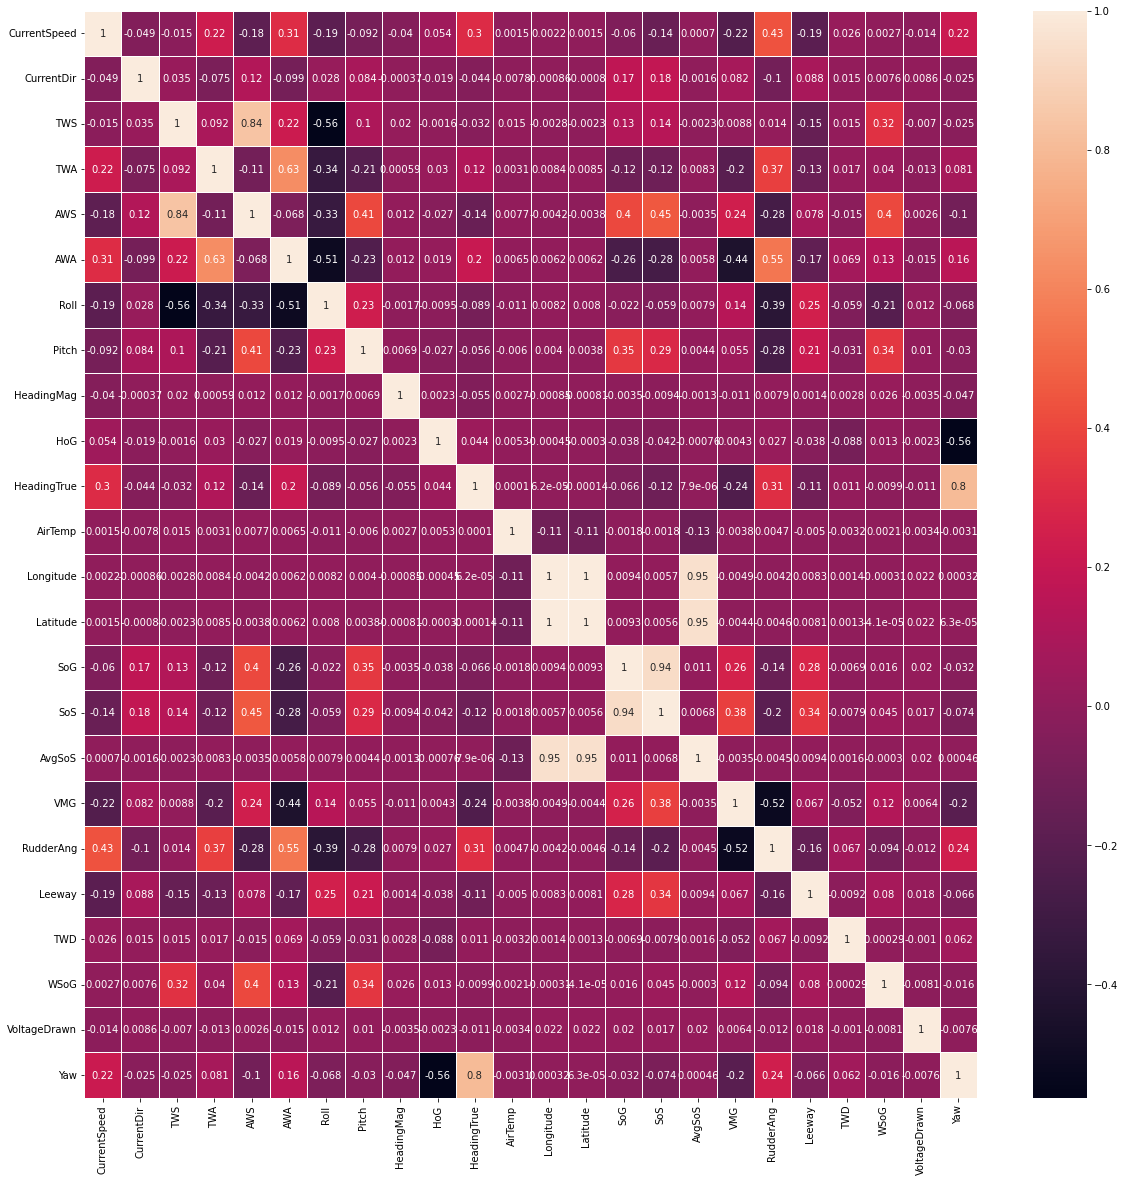

In [246]:
# Make nice and colorful plot of matrix
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
plt.show()

In [44]:
# drop certain columns due to multicolinearity (not always)
scaled_df = scaled_df.drop(['HoG', 'HeadingTrue', 'AvgSoS'], axis=1)

In [247]:
# Tested 3 set-ups before PCA
# With and without HoG, HT and AvgSoS with 95% var explained
# Without above and 90% var

# Dimensionality reduction
array_x_pca = np.array(scaled_df)

# Create the PCA instance
pca = PCA(n_components = 0.95)

# Fit on data
pca.fit(array_x_pca)

# Access values and vectors
print(pca.explained_variance_)

# Transform data
smol_scaled = pca.transform(array_x_pca)

[0.75195117 0.59076304 0.44865734 0.27240119 0.16842283 0.15317097
 0.12095606 0.11459673 0.09810257 0.08651268 0.08183508 0.07992624
 0.07113382 0.06895607 0.04912549]


In [248]:
smol_scaled2 = pd.DataFrame(smol_scaled)

In [249]:
# Combined numeric and ModePilote
cat_df = data.loc[1:, ['ModePilote', 'Tacking', 'DateTime']]
cat_df.index = range(199999)
full_df = pd.concat([smol_scaled2, cat_df], axis=1, ignore_index=True)
full_df.set_index(17, inplace=True)
full_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
17,,,,,,,,,,,,,,,,,
2019-04-14 00:00:01,0.000444,-0.021663,-0.001293,-0.005984,0.007590,-0.013866,-0.001500,0.008712,0.055009,0.041232,-0.007113,0.002683,-0.021988,-0.005487,0.002485,1.0,1.0
2019-04-14 00:00:02,0.000295,-0.021661,-0.002702,-0.008870,0.008788,-0.013138,-0.001567,0.008539,0.055053,0.041046,-0.007234,0.002725,-0.022556,-0.005575,0.006290,1.0,1.0
2019-04-14 00:00:03,0.000111,-0.021672,-0.001249,-0.004438,0.005556,-0.015246,-0.001423,0.008880,0.055367,0.042513,-0.007163,0.002620,-0.016421,-0.009405,-0.000263,1.0,1.0
2019-04-14 00:00:04,0.000111,-0.021672,-0.001249,-0.004438,0.005556,-0.015246,-0.001423,0.008880,0.055367,0.042513,-0.007163,0.002620,-0.016421,-0.009405,-0.000263,1.0,1.0
2019-04-14 00:00:05,-0.000036,-0.021658,-0.002304,-0.004795,0.002740,-0.006202,-0.000272,0.003742,0.023859,0.018961,-0.002922,0.001173,-0.004938,-0.004878,0.002681,1.0,1.0


In [250]:
# Try with simple resampling to get more coarse data
# Make Tacking binary again (slightly problematic)
data_down = full_df.copy()
data_down = data_down.resample('1T').mean()
data_down[16] = [1 if item > 0.5 else 0 for item in data_down[16]]

In [251]:
# Pick out data, rewritten function from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""

	n_vars = data.shape[1]
	df = pd.DataFrame(data)
	target = df.iloc[:,-1]
	# df = df.iloc[:,:-1]
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, -1, -1):
		cols.append(df.shift(i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# forecast sequence
	cols.append(target.shift(-30))
	names.append('Tacking')
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [252]:
supervised_df = series_to_supervised(data_down.values, n_in=5)
supervised_df.shape

(3299, 103)

In [161]:
# Remaking the DF without PCA to port into R for visualization

# Scale numeric features
scaled = StandardScaler().fit_transform(X_numeric.values)
scaled = pd.DataFrame(scaled, columns=X_numeric.columns)

scaled = pd.DataFrame(scaled)

# Combined numeric and ModePilote
cat_df = data.loc[1:, ['ModePilote', 'Tacking', 'DateTime']]
cat_df.index = range(199999)
full_df2 = pd.concat([scaled, cat_df], axis=1, ignore_index=True)
full_df2.set_index(26, inplace=True)
full_df2.head()

full_df2.to_csv('C:/Users/samue/Documents/to_r_tdab_full.csv')

data.to_csv('C:/Users/samue/Documents/to_r_tdab_raw.csv')

data_down2 = full_df2.copy()
data_down2 = data_down2.resample('1T').mean()
data_down2[25] = [1 if item > 0.5 else 0 for item in data_down2[25]]

supervised_df2 = series_to_supervised(data_down2.values, n_in=5)
supervised_df2.shape

supervised_df2.to_csv('C:/Users/samue/Documents/to_r_tdab_super.csv')

In [253]:
# Split into train and test sets
values = supervised_df.values
n_train = int(round(values.shape[0]*0.7, 0))
train = values[:n_train, :]
test = values[n_train:, :]

# Split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

In [225]:
# Make CV function
# Can also run it on roc_auc
from itertools import product

def custom_CV(X_train, y_train, X_test, y_test, parameters):

    param_list = list(product(*parameters.values()))

    best_acc = 0

    for i, row in enumerate(param_list):
        xgb_mod = xgb.XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss',
        eta = row[0], min_child_weight = row[1], gamma = row[2], subsample = row[3],
        colsample_bytree = row[4], max_depth = row[5], scale_pos_weight = row[6],
        reg_alpha = row[7], reg_lambda = row[8])

        xgb_mod.fit(X_train, y_train)
            
        y_pred = [1 if item[1] > 0.5 else 0 for item in xgb_mod.predict_proba(X_test)]

        if accuracy_score(y_test, y_pred) > best_acc:
            best_acc = accuracy_score(y_test, y_pred)
            best_params = xgb_mod.get_params

        if i % 1000 == 0:
            print(f'Current iteration is: {i}. Best accuracy is {best_acc}')
    
    return best_acc, best_params

In [254]:
dist = {
        'eta': [0.1, 0.2, 0.3],
        'min_child_weight': [5, 10],
        'gamma': [0, 1.0, 10],
        'subsample': np.arange(0.5, 1, 0.1),
        'colsample_bytree': np.arange(0.5, 1, 0.1),
        'max_depth': np.arange(3, 10, 2),
        'scale_pos_weight': [5, 10],
        'reg_alpha': [1, 10.0, 100.0],
        'reg_lambda': [1, 10.0, 100.0]
        }

best_acc, best_params = custom_CV(X_train, y_train, X_test, y_test, dist)

Current iteration is: 0. Best accuracy is 0.902020202020202
Current iteration is: 1000. Best accuracy is 0.9393939393939394
Current iteration is: 2000. Best accuracy is 0.9393939393939394
Current iteration is: 3000. Best accuracy is 0.9393939393939394
Current iteration is: 4000. Best accuracy is 0.9393939393939394
Current iteration is: 5000. Best accuracy is 0.9393939393939394
Current iteration is: 6000. Best accuracy is 0.9393939393939394
Current iteration is: 7000. Best accuracy is 0.9393939393939394
Current iteration is: 8000. Best accuracy is 0.9393939393939394
Current iteration is: 9000. Best accuracy is 0.9393939393939394
Current iteration is: 10000. Best accuracy is 0.9393939393939394
Current iteration is: 11000. Best accuracy is 0.9393939393939394
Current iteration is: 12000. Best accuracy is 0.9393939393939394
Current iteration is: 13000. Best accuracy is 0.9393939393939394
Current iteration is: 14000. Best accuracy is 0.9393939393939394
Current iteration is: 15000. Best accur

In [255]:
best_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8999999999999999,
              enable_categorical=False, eta=0.1, eval_metric='logloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=100.0,
              reg_lambda=10.0, scale_pos_weight=5, subsample=0.5,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)>

In [ ]:
# 30 min forward, no back lag, by 30 min
# roc_auc = .833

xgb_mod = xgb.XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss',
        eta = 0.1, min_child_weight = 10, gamma = 0, subsample = 0.5,
        colsample_bytree = 0.8, max_depth = 3, scale_pos_weight = 5,
        reg_alpha = 1, reg_lambda = 10)

xgb_mod.fit(X_train, y_train)

y_pred = [1 if item[1] > 0.5 else 0 for item in xgb_mod.predict_proba(X_test)]

print(classification_report(y_test, y_pred))

print(roc_auc_score(y_test, y_pred))

In [242]:
# Without tacking during for previous steps
xgb_mod = xgb.XGBClassifier(colsample_bytree=0.5, eta=0.2, eval_metric='logloss',
              gamma=0, max_depth=5, min_child_weight=5, random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=5, subsample=0.9, 
              use_label_encoder=False)

xgb_mod.fit(X_train, y_train)

y_pred = [1 if item[1] > 0.5 else 0 for item in xgb_mod.predict_proba(X_test)]

print(classification_report(y_test, y_pred))

print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95       898
         1.0       0.00      0.00      0.00        92

    accuracy                           0.90       990
   macro avg       0.45      0.50      0.47       990
weighted avg       0.82      0.90      0.86       990

0.49721603563474387


#### This is the best model

In [257]:
# 5 min back, 30 min forward, by 1 min
# acc = 0.94
# roc_auc = 0.8035

xgb_mod = xgb.XGBClassifier(colsample_bytree=0.8999999999999999,
              enable_categorical=False, eta=0.1, eval_metric='logloss', gamma=0,
              max_depth=3,
              min_child_weight=5, random_state=0, reg_alpha=100.0,
              reg_lambda=10.0, scale_pos_weight=5, subsample=0.5,
              use_label_encoder=False)

xgb_mod.fit(X_train, y_train)

y_pred = [1 if item[1] > 0.5 else 0 for item in xgb_mod.predict_proba(X_test)]

print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       898
         1.0       0.67      0.67      0.67        92

    accuracy                           0.94       990
   macro avg       0.82      0.82      0.82       990
weighted avg       0.94      0.94      0.94       990

0.8202527355475937


In [53]:
# 10 min back, 30 min forward, by 1 min
# All variables, PCA .95
# roc_auc = .876868

xgb_mod = xgb.XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss',
        eta = 0.2, min_child_weight = 5, gamma = 10, subsample = 0.8,
        colsample_bytree = 0.9, max_depth = 3, scale_pos_weight = 10,
        reg_alpha = 10, reg_lambda = 100)

xgb_mod.fit(X_train, y_train)

y_pred = [1 if item[1] > 0.5 else 0 for item in xgb_mod.predict_proba(X_test)]

print(classification_report(y_test, y_pred))

print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       896
         1.0       0.59      0.68      0.64        92

    accuracy                           0.93       988
   macro avg       0.78      0.82      0.80       988
weighted avg       0.93      0.93      0.93       988

0.8183957686335405


In [64]:
# 10 min back, 30 min forward, by 1min
# PCA = .9, removed 3 variables
# roc_score = .84

xgb_mod = xgb.XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss',
        eta = 0.2, min_child_weight = 5, gamma = 0, subsample = 0.7,
        colsample_bytree = 0.6, max_depth = 3, scale_pos_weight = 10,
        reg_alpha = 1, reg_lambda = 100)

xgb_mod.fit(X_train, y_train)

y_pred = [1 if item[1] > 0.5 else 0 for item in xgb_mod.predict_proba(X_test)]

print(classification_report(y_test, y_pred))

print(roc_auc_score(y_test, y_pred))

In [153]:
supervised_df.columns

Index(['var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var6(t-5)', 'var7(t-5)', 'var8(t-5)', 'var9(t-5)', 'var10(t-5)',
       ...
       'var10(t)', 'var11(t)', 'var12(t)', 'var13(t)', 'var14(t)', 'var15(t)',
       'var16(t)', 'var17(t)', 'var18(t)', 'Tacking'],
      dtype='object', length=109)

In [154]:
# Get feature names and importance
feature_names = supervised_df.columns.tolist()
feature_names.remove('Tacking')

plot_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_mod.feature_importances_
})

## General CV

In [228]:
def custom_CV_v2(mod, X_train, y_train, X_test, y_test, parameters):

    param_list = list(product(*parameters.values()))

    best_acc = 0

    for i, row in enumerate(param_list):

        mod_dict = {key: value for (key, value) in zip(parameters.keys(), row)}

        mod = mod.set_params(**mod_dict)
        mod.fit(X_train, y_train)
            
        y_pred = mod.predict(X_test)

        if accuracy_score(y_test, y_pred) > best_acc:
            best_acc = accuracy_score(y_test, y_pred)
            best_params = mod.get_params

        if i % 10 == 0:
            print(f'Current iteration is: {i}. Best accuracy is {best_acc}')
    
    return best_acc, best_params

## LDA

In [258]:
# Upsampling

from imblearn.over_sampling import SMOTE

SMOTE = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

In [259]:
# LDA
# Start with solver
grid = {'solver': ['svd', 'lsqr', 'eigen']}

lda_mod = LinearDiscriminantAnalysis()
best_acc, best_params = custom_CV_v2(lda_mod, X_train_SMOTE, y_train_SMOTE, X_test, y_test, grid)
print(f'Best accuracy: {best_acc}.\nBest params: {best_params}')

Current iteration is: 0. Best accuracy is 0.9373737373737374
Best accuracy: 0.9373737373737374.
Best params: <bound method BaseEstimator.get_params of LinearDiscriminantAnalysis(solver='eigen')>


In [261]:
# accuracy = .93939
lda_mod = LinearDiscriminantAnalysis(solver='eigen')
lda_mod.fit(X_train_SMOTE, y_train_SMOTE)
y_pred = lda_mod.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       898
         1.0       0.67      0.65      0.66        92

    accuracy                           0.94       990
   macro avg       0.82      0.81      0.81       990
weighted avg       0.94      0.94      0.94       990

0.8093831703302024


## QDA

In [262]:
# QDA

grid = {'reg_param': [0, 0.1, 0.2, 0.3, 0.4, 0.5]}

qda_mod = QuadraticDiscriminantAnalysis()
best_acc, best_params = custom_CV_v2(qda_mod, X_train_SMOTE, y_train_SMOTE, X_test, y_test, grid)
print(f'Best accuracy: {best_acc}.\nBest params: {best_params}')

Current iteration is: 0. Best accuracy is 0.8868686868686869
Best accuracy: 0.9222222222222223.
Best params: <bound method BaseEstimator.get_params of QuadraticDiscriminantAnalysis(reg_param=0.5)>


In [263]:
# accuracy = .9222
qda_mod = QuadraticDiscriminantAnalysis(reg_param=0.5)
qda_mod.fit(X_train_SMOTE, y_train_SMOTE)
y_pred = qda_mod.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       898
         1.0       0.57      0.63      0.60        92

    accuracy                           0.92       990
   macro avg       0.77      0.79      0.78       990
weighted avg       0.93      0.92      0.92       990

0.7912752977631452


## SVM

In [264]:
# SVM
svm_mod = SVC(random_state=0)

# First test if linear kernel is selected
# grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

# As linear kernel is not best, also tune other parameters
grid = {
    'C': [.01, .1, 1, 10],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'gamma': ['auto', 10, 1, .1, .01, .001]
}

best_acc, best_params = custom_CV_v2(svm_mod, X_train_SMOTE, y_train_SMOTE, X_test, y_test, grid)
print(f'Best accuracy: {best_acc}.\nBest params: {best_params}')

Current iteration is: 0. Best accuracy is 0.09292929292929293
Current iteration is: 10. Best accuracy is 0.9343434343434344
Current iteration is: 20. Best accuracy is 0.9343434343434344
Current iteration is: 30. Best accuracy is 0.9353535353535354
Current iteration is: 40. Best accuracy is 0.9353535353535354
Current iteration is: 50. Best accuracy is 0.9353535353535354
Current iteration is: 60. Best accuracy is 0.9393939393939394
Current iteration is: 70. Best accuracy is 0.9393939393939394
Best accuracy: 0.9393939393939394.
Best params: <bound method BaseEstimator.get_params of SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=0)>


In [265]:
# accuracy = .93939
svm_mod = SVC(C=10, gamma=0.001, kernel='sigmoid', random_state=0)
svm_mod.fit(X_train_SMOTE, y_train_SMOTE)
y_pred = svm_mod.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       898
         1.0       0.65      0.65      0.65        92

    accuracy                           0.94       990
   macro avg       0.81      0.81      0.81       990
weighted avg       0.94      0.94      0.94       990

0.8082695845840999


## KNN

In [266]:
# KNN Classifier object
knn = KNeighborsClassifier()
# Hyperparameters
grid = dict(n_neighbors=list(range(1, 100)))

best_acc, best_params = custom_CV_v2(knn, X_train_SMOTE, y_train_SMOTE, X_test, y_test, grid)
print(f'Best accuracy: {best_acc}.\nBest params: {best_params}')

Current iteration is: 0. Best accuracy is 0.798989898989899
Current iteration is: 10. Best accuracy is 0.8484848484848485
Current iteration is: 20. Best accuracy is 0.8737373737373737
Current iteration is: 30. Best accuracy is 0.8929292929292929
Current iteration is: 40. Best accuracy is 0.9101010101010101
Current iteration is: 50. Best accuracy is 0.9222222222222223
Current iteration is: 60. Best accuracy is 0.9323232323232323
Current iteration is: 70. Best accuracy is 0.9353535353535354
Current iteration is: 80. Best accuracy is 0.9363636363636364
Current iteration is: 90. Best accuracy is 0.9363636363636364
Best accuracy: 0.9363636363636364.
Best params: <bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=99)>


In [267]:
# accuracy = .93939
knn = KNeighborsClassifier(n_neighbors=199)
knn.fit(X_train_SMOTE, y_train_SMOTE)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       898
         1.0       0.61      0.64      0.63        92

    accuracy                           0.93       990
   macro avg       0.79      0.80      0.79       990
weighted avg       0.93      0.93      0.93       990

0.8000508376101481


## Predicting time to tack

In [82]:
cat_df = data.loc[1:, ['ModePilote', 'time_to_tack']]
full_df = pd.concat([scaled_df, cat_df], axis=1, ignore_index=True)
full_df = full_df.dropna()

In [83]:
# Split into train and test sets
values = full_df.values
n_train_hours = int(round(values.shape[0]*0.7, 0))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

In [90]:
xgb_mod = xgb.XGBRegressor(random_state=47, eta=0.2, min_child_weight=5, gamma=0.1,
subsample=0.8, colsample_bytree=0.8, max_depth=8, reg_alpha=1, reg_lambda=1)

xgb_mod.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.2, gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.200000003,
             max_delta_step=0, max_depth=8, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=47,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [91]:
y_pred = xgb_mod.predict(X_test)
print(r2_score(y_test, y_pred))

-2.194805435586546
